# Tahap 1: Data Preprocessing & Validation

Tahap ini bertujuan untuk mempersiapkan dataset mentah (*raw data*) menjadi dataset bersih yang siap digunakan oleh mesin simulasi `SimPy`. Kualitas data sangat krusial karena simulasi *Discrete Event* sangat sensitif terhadap urutan waktu (*chronological order*) dan validitas numerik.

### 🎯 Tujuan
1.  **Format Consistency:** Memastikan kolom waktu terbaca sebagai objek `datetime`, bukan teks (string).
2.  **Noise Reduction:** Menghapus data yang tidak relevan (durasi < 1 menit) yang dapat mendistorsi hasil antrean.
3.  **Chronological Sorting:** Mengurutkan data berdasarkan waktu kedatangan (`Start Time`) secara *ascending* (mutlak diperlukan oleh SimPy).

### ⚙️ Langkah Pembersihan
1.  **Load Data:** Membaca file CSV sampel (5.000 baris).
2.  **Type Casting:** Mengonversi kolom `Start Time` ke tipe `datetime64[ns]`.
3.  **Sanity Check:** Memfilter data dengan logika durasi parkir (`Duration >= 1 minute`).
4.  **Sorting:** Mengurutkan ulang indeks data berdasarkan waktu masuk.

In [4]:
import pandas as pd
import numpy as np

# --- KONFIGURASI ---
# Ganti dengan nama file csv 5000 baris yang sudah Anda buat sebelumnya
nama_file_input = r'C:\Users\Rahayu Febrianti\Downloads\UAS_PS\parkir.csv' 
nama_file_output = 'dataset_ready_for_simpy.csv'

# 1. LOAD DATA
print(f"--- MEMUAT DATA DARI {nama_file_input} ---")
try:
    df = pd.read_csv(nama_file_input)
    print(f"Data awal: {len(df)} baris")
except FileNotFoundError:
    print("Error: File tidak ditemukan. Pastikan nama file sesuai!")
    df = pd.DataFrame() # Empty dataframe to prevent next errors

if not df.empty:
    # 2. BERSIHKAN NAMA KOLOM
    # Kadang ada spasi tersembunyi, misal " Start Time " -> "Start Time"
    df.columns = df.columns.str.strip()
    
    # 3. FORMAT TANGGAL (TYPE CASTING)
    # Ubah string menjadi objek datetime agar bisa dihitung selisihnya
    print("\n--- KONVERSI FORMAT WAKTU ---")
    df['Start Time'] = pd.to_datetime(df['Start Time'], errors='coerce')
    
    # Jika ada kolom End Time, kita format juga (opsional, untuk validasi)
    if 'End Time' in df.columns:
        df['End Time'] = pd.to_datetime(df['End Time'], errors='coerce')
    
    # Hapus baris yang gagal dikonversi (NaT)
    df = df.dropna(subset=['Start Time'])
    
    # 4. SORTING KRONOLOGIS (WAJIB UNTUK SIMPY)
    # Data harus urut dari jam 00:00 ke 23:59
    df = df.sort_values(by='Start Time')
    
    # 5. VALIDASI LOGIKA (SANITY CHECK)
    print("\n--- VALIDASI LOGIKA DATA ---")
    awal_len = len(df)
    
    # Filter A: Durasi Parkir harus positif dan masuk akal
    # Kita buang yang durasinya < 1 menit (dianggap cuma lewat/drop-off/error)
    # Pastikan kolom durasi ada (sesuaikan nama kolom dengan CSV Anda)
    col_durasi = 'Duration in Minutes' # Ganti jika nama kolom di CSV Anda beda
    
    if col_durasi in df.columns:
        # Pastikan tipe data float/numeric
        df[col_durasi] = pd.to_numeric(df[col_durasi], errors='coerce')
        
        # Buang data durasi < 1 menit atau NaN
        df = df[df[col_durasi] >= 1]
        print(f"- Dibuang {awal_len - len(df)} baris karena durasi < 1 menit atau error.")
    else:
        print(f"PERINGATAN: Kolom '{col_durasi}' tidak ditemukan. Cek nama kolom di CSV!")

    # Filter B: Cek Duplikat
    len_before_dedup = len(df)
    df = df.drop_duplicates()
    if len_before_dedup - len(df) > 0:
        print(f"- Dibuang {len_before_dedup - len(df)} baris duplikat.")

    # 6. SIMPAN DATA BERSIH
    print("\n--- MENYIMPAN HASIL ---")
    df.to_csv(nama_file_output, index=False)
    print(f"Total Data Bersih: {len(df)} baris.")
    print(f"File disimpan sebagai: {nama_file_output}")
    
    # 7. PREVIEW DATA
    print("\n--- 5 DATA PERTAMA ---")
    print(df[['Start Time', col_durasi]].head())
    print("\n--- TIPE DATA ---")
    print(df[['Start Time', col_durasi]].dtypes)

else:
    print("Proses berhenti karena data kosong.")

--- MEMUAT DATA DARI C:\Users\Rahayu Febrianti\Downloads\UAS_PS\parkir.csv ---
Data awal: 4999 baris

--- KONVERSI FORMAT WAKTU ---

--- VALIDASI LOGIKA DATA ---
- Dibuang 1 baris karena durasi < 1 menit atau error.

--- MENYIMPAN HASIL ---
Total Data Bersih: 4998 baris.
File disimpan sebagai: dataset_ready_for_simpy.csv

--- 5 DATA PERTAMA ---
           Start Time  Duration in Minutes
0 2020-01-15 21:49:00            129.83333
1 2020-02-01 19:50:00            180.00000
2 2020-07-11 19:26:00            100.00000
3 2020-07-15 16:57:00            180.00000
4 2020-09-16 14:01:00            478.00000

--- TIPE DATA ---
Start Time             datetime64[ns]
Duration in Minutes           float64
dtype: object


# Tahap 2: Exploratory Data Analysis (EDA) & Time Compression Strategy

Setelah data dibersihkan, tahap selanjutnya adalah menganalisis kepadatan lalu lintas (*traffic density*). Berdasarkan analisis awal, ditemukan bahwa data asli memiliki rentang waktu yang sangat luas (2020-2021) dengan intensitas kedatangan yang rendah (jarang), sehingga tidak ideal untuk simulasi antrean (*congestion simulation*).

### ⚠️ Masalah: Data Sparsity
Data asli memiliki *Inter-arrival Time* rata-rata > 160 menit. Jika digunakan langsung, simulasi tidak akan pernah mengalami antrean (sistem selalu *idle*), sehingga perbandingan Algoritma Manual vs Smart tidak akan terlihat bedanya.

### 🛠️ Solusi: Time Compression (Kompresi Waktu)
Untuk mengatasi hal tersebut, dilakukan teknik manipulasi data dengan strategi berikut:
1.  **Filtering:** Hanya mengambil sampel data dari tahun dengan volume terbanyak (2021).
2.  **Compression:** Memetakan ulang (*re-mapping*) seluruh data kedatangan selama 1 tahun ke dalam jendela simulasi **1 Minggu (7 Hari)**.
3.  **Pattern Preservation:** Pola jam kedatangan (*Hour & Minute*) tetap dipertahankan sesuai data asli untuk menjaga karakteristik "Jam Sibuk" (*Peak Hour*), namun tanggalnya dipadatkan.

**Output:** Dataset baru (`dataset_final_compressed.csv`) dengan kepadatan tinggi yang siap menguji batas kemampuan kapasitas parkir.

--- JUMLAH DATA PER TAHUN ---
Year
2020       6
2021    4992
Name: count, dtype: int64


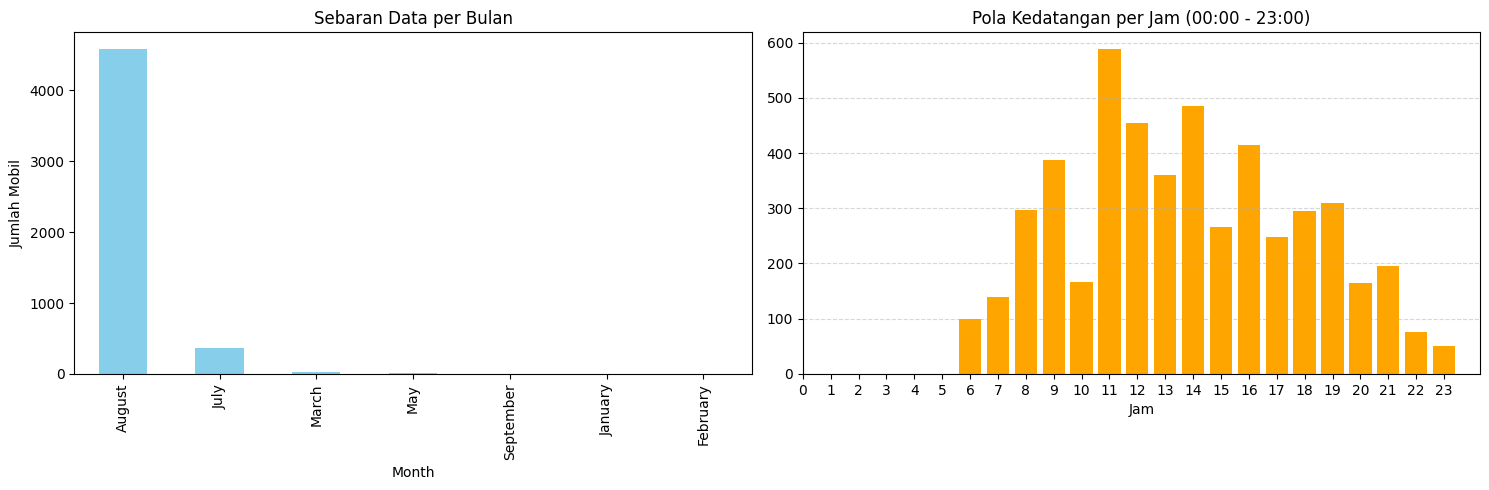


--- STATISTIK KEPADATAN ---
Rata-rata selisih kedatangan mobil: 166.80 menit
⚠️ PERINGATAN: Trafik sangat sepi! (Mobil datang jarang-jarang)
Saran: Kita mungkin perlu memfilter data di 1 bulan tersibuk saja, atau memanipulasi waktu agar lebih padat.


In [5]:
import matplotlib.pyplot as plt

# --- 1. MEMBUAT FITUR TAMBAHAN UNTUK ANALISIS ---
# Kita ekstrak Tahun, Bulan, dan Jam dari kolom 'Start Time'
df['Year'] = df['Start Time'].dt.year
df['Month'] = df['Start Time'].dt.month_name()
df['Hour'] = df['Start Time'].dt.hour

# --- 2. CEK SEBARAN TAHUN ---
print("--- JUMLAH DATA PER TAHUN ---")
print(df['Year'].value_counts().sort_index())

# --- 3. VISUALISASI KEPADATAN ---
plt.figure(figsize=(15, 5))

# Plot A: Kepadatan per Bulan (Apakah data menyebar rata?)
plt.subplot(1, 2, 1)
df['Month'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sebaran Data per Bulan')
plt.ylabel('Jumlah Mobil')

# Plot B: Kepadatan per Jam (Mencari Peak Hour)
plt.subplot(1, 2, 2)
hourly_counts = df['Hour'].value_counts().sort_index()
plt.bar(hourly_counts.index, hourly_counts.values, color='orange')
plt.title('Pola Kedatangan per Jam (00:00 - 23:00)')
plt.xlabel('Jam')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- 4. CEK 'INTER-ARRIVAL TIME' (SELISIH KEDATANGAN) ---
# Ini indikator macet paling akurat.
# Jika rata-rata selisihnya > 10 menit, berarti parkiran SEPI.
# Jika rata-rata selisihnya < 1 menit, berarti parkiran PADAT.
df['inter_arrival_minutes'] = df['Start Time'].diff().dt.total_seconds() / 60
avg_inter_arrival = df['inter_arrival_minutes'].mean()

print(f"\n--- STATISTIK KEPADATAN ---")
print(f"Rata-rata selisih kedatangan mobil: {avg_inter_arrival:.2f} menit")

if avg_inter_arrival > 5:
    print("⚠️ PERINGATAN: Trafik sangat sepi! (Mobil datang jarang-jarang)")
    print("Saran: Kita mungkin perlu memfilter data di 1 bulan tersibuk saja, atau memanipulasi waktu agar lebih padat.")
else:
    print("✅ BAGUS: Trafik cukup padat untuk simulasi.")

Sisa data tahun 2021: 4992 baris

--- MELAKUKAN KOMPRESI WAKTU ---
Strategi: Memadatkan data 1 tahun menjadi 1 minggu simulasi.
Rentang Waktu Baru: 2024-01-01 06:00:00 s.d 2024-01-07 23:43:00
Rata-rata selisih kedatangan (Baru): 1.94 menit


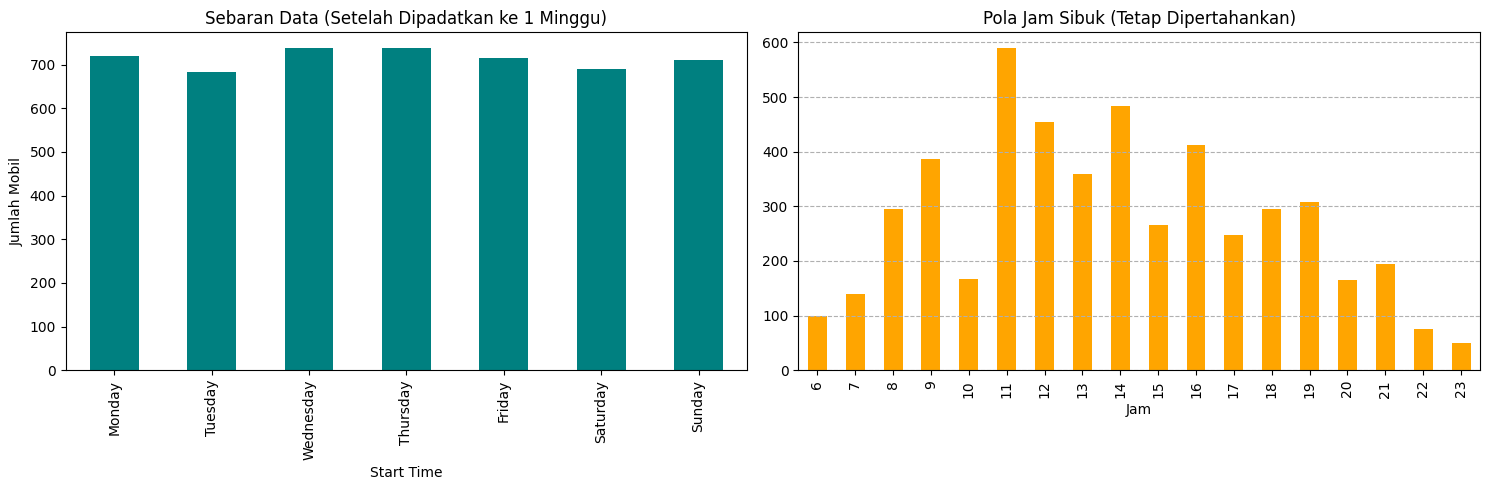


Dataset padat tersimpan sebagai: dataset_final_compressed.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. FILTER TAHUN ---
# Kita buang data 2020 (karena cuma 6 biji, mengganggu statistik)
df = df[df['Start Time'].dt.year == 2021].copy()
print(f"Sisa data tahun 2021: {len(df)} baris")

# --- 2. TEKNIK "TIME COMPRESSION" (INTI MANIPULASI) ---
print("\n--- MELAKUKAN KOMPRESI WAKTU ---")
print("Strategi: Memadatkan data 1 tahun menjadi 1 minggu simulasi.")

# Kita tetapkan tanggal simulasi mulai dari Senin, 1 Januari 2024 (Tanggal fiktif)
sim_start_date = pd.to_datetime("2024-01-01") 

# Logika:
# 1. Ambil JAM dan MENIT asli (pola kedatangan dipertahankan).
# 2. Ganti TANGGALNYA menjadi acak antara hari ke-0 s.d hari ke-6 (Senin-Minggu).

# Ambil komponen waktu asli
original_times = df['Start Time'].dt.time

# Bikin offset hari secara acak (0 sampai 6) untuk setiap mobil
# np.random.seed(42) # (Opsional) Supaya hasil acaknya tetap sama terus
random_days = np.random.randint(0, 7, size=len(df))

# Gabungkan menjadi datetime baru
new_timestamps = []
for t, day_offset in zip(original_times, random_days):
    # Gabungkan: Tanggal Dasar + Offset Hari + Jam Asli
    new_ts = sim_start_date + pd.Timedelta(days=day_offset) + \
             pd.Timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    new_timestamps.append(new_ts)

# Timpa kolom Start Time dengan waktu simulasi baru
df['Start Time'] = new_timestamps

# PENTING: Urutkan ulang karena pengacakan hari membuat urutan berantakan
df = df.sort_values(by='Start Time').reset_index(drop=True)

# --- 3. CEK KEPADATAN BARU ---
# Hitung selisih waktu lagi (Inter-arrival)
df['inter_arrival_minutes'] = df['Start Time'].diff().dt.total_seconds() / 60
avg_inter_arrival = df['inter_arrival_minutes'].mean()

print(f"Rentang Waktu Baru: {df['Start Time'].min()} s.d {df['Start Time'].max()}")
print(f"Rata-rata selisih kedatangan (Baru): {avg_inter_arrival:.2f} menit")

# --- 4. VISUALISASI HASIL MANIPULASI ---
plt.figure(figsize=(15, 5))

# Plot A: Kepadatan per Hari Simulasi
plt.subplot(1, 2, 1)
df['Start Time'].dt.day_name().value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar', color='teal')
plt.title('Sebaran Data (Setelah Dipadatkan ke 1 Minggu)')
plt.ylabel('Jumlah Mobil')

# Plot B: Pola Jam (Tetap Asli)
plt.subplot(1, 2, 2)
df['Start Time'].dt.hour.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Pola Jam Sibuk (Tetap Dipertahankan)')
plt.xlabel('Jam')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# --- 5. SIMPAN DATASET SIAP SIMULASI ---
df.to_csv('dataset_final_compressed.csv', index=False)
print("\nDataset padat tersimpan sebagai: dataset_final_compressed.csv")

In [7]:
# --- CEK PEAK OCCUPANCY (KEPADATAN MAKSIMUM) ---
# Kita hitung berapa mobil yang 'overlap' (masih parkir) di setiap menitnya.

# Load data baru
df_sim = pd.read_csv('dataset_final_compressed.csv')
df_sim['Start Time'] = pd.to_datetime(df_sim['Start Time'])
df_sim['End Time'] = df_sim['Start Time'] + pd.to_timedelta(df_sim['Duration in Minutes'], unit='m')

# Buat timeline per menit selama 1 minggu
timeline = pd.date_range(start=df_sim['Start Time'].min(), end=df_sim['End Time'].max(), freq='1min')
occupancy_data = []

print("Sedang menghitung okupansi maks... (Mungkin butuh 10-20 detik)")

# (Cara Cepat) Kita pakai pendekatan kumulatif
# Masuk = +1, Keluar = -1
events = []
for t in df_sim['Start Time']:
    events.append((t, 1))
for t in df_sim['End Time']:
    events.append((t, -1))

# Urutkan event berdasarkan waktu
events.sort()

# Hitung kumulatif
current_cars = 0
max_cars = 0
occupancy_over_time = []

for t, change in events:
    current_cars += change
    max_cars = max(max_cars, current_cars)
    occupancy_over_time.append(current_cars)

print(f"\n--- HASIL ANALISIS KAPASITAS ---")
print(f"Jumlah mobil maksimum yang parkir bersamaan: {max_cars} mobil")
print(f"Saran Kapasitas untuk Simulasi: {int(max_cars * 0.9)} (90% dari maks)")
print("(Agar terjadi antrean di jam sibuk, kapasitas harus di bawah peak demand)")

Sedang menghitung okupansi maks... (Mungkin butuh 10-20 detik)

--- HASIL ANALISIS KAPASITAS ---
Jumlah mobil maksimum yang parkir bersamaan: 164 mobil
Saran Kapasitas untuk Simulasi: 147 (90% dari maks)
(Agar terjadi antrean di jam sibuk, kapasitas harus di bawah peak demand)


# Tahap 3: Implementasi Model Simulasi (SimPy)

Pada tahap ini, dibangun model *Discrete Event Simulation* menggunakan library `SimPy`. Model ini menggunakan pendekatan **Hybrid**, di mana:
1.  **Traffic Flow:** Menggunakan data riil (yang sudah dikompresi) untuk jadwal kedatangan.
2.  **Resource Constraint:** Kapasitas parkir dibatasi sebesar **147 Slot** (90% dari Peak Demand).
3.  **Behavior Logic:** Perilaku pengemudi dibedakan berdasarkan skenario:
    * **Skenario Manual:** Waktu cari parkir (*Cruising Time*) meningkat secara eksponensial seiring kepadatan parkir. Rumus: `Base + (Occupancy * RandomFactor)`.
    * **Skenario Smart:** Waktu cari parkir stabil dan efisien karena dipandu sensor. Rumus: `Base + TravelTime`.

In [8]:
import simpy
import pandas as pd
import random

# --- KONFIGURASI GLOBAL ---
KAPASITAS_PARKIR = 147  # Sesuai hasil analisis Tahap sebelumnya
FILE_DATASET = 'dataset_final_compressed.csv'

# --- 1. LOGIKA PERILAKU PENGEMUDI (ALGORITMA) ---
def calculate_search_time(env, parking_lot, scenario):
    """
    Menghitung durasi 'Cruising' (Mencari Slot) berdasarkan kepadatan saat itu.
    """
    # Hitung persentase kepenuhan (0.0 s.d 1.0)
    # parking_lot.count = jumlah mobil yang sedang parkir
    occupancy = parking_lot.count / parking_lot.capacity
    
    if scenario == 'MANUAL':
        # TEORI: Semakin penuh, semakin susah mencari (Blind Search)
        # Jika kosong: butuh 1 menit.
        # Jika 100% penuh: butuh 1 + (15 menit * 1.0) = 16 menit muter-muter.
        base_search = 1.0
        confusion_factor = random.uniform(5, 15) # Faktor kebingungan (acak)
        return base_search + (occupancy * confusion_factor)
        
    elif scenario == 'SMART':
        # TEORI: Dipandu sensor, langsung ke slot kosong terdekat
        # Waktu stabil, tidak peduli seberapa penuh (selama ada slot)
        base_search = 1.0
        travel_distance = random.uniform(0.5, 2.0) # Jarak tempuh ke slot
        return base_search + travel_distance

# --- 2. PROSES MOBIL (AGEN) ---
def car_process(env, name, parking_lot, duration_park, stats, scenario):
    
    # A. Waktu Datang
    arrival_time = env.now
    
    # B. Antre di Gerbang (Rebutan Slot)
    # Mobil minta slot. Jika penuh, dia diam di sini (antre).
    with parking_lot.request() as request:
        yield request 
        
        # C. Masuk Area Parkir
        enter_gate_time = env.now
        queue_time = enter_gate_time - arrival_time # Waktu tunggu di gerbang
        
        # D. Mencari Parkir (Cruising) - INI PEMBEDANYA
        search_duration = calculate_search_time(env, parking_lot, scenario)
        yield env.timeout(search_duration)
        
        # E. Parkir (Menahan Slot)
        start_parking_time = env.now
        yield env.timeout(duration_park) # Diam selama durasi parkir
        
        # F. Keluar
        stats.append({
            'Scenario': scenario,
            'Car_ID': name,
            'Arrival_Time': arrival_time,
            'Queue_Time': queue_time,       # Berapa lama nunggu di gate
            'Search_Time': search_duration, # Berapa lama cari slot
            'Parking_Duration': duration_park
        })

# --- 3. FUNGSI JALAN SIMULASI (ENGINE) ---
def run_scenario(scenario_name):
    print(f"🔄 Menjalankan Skenario: {scenario_name}...")
    
    # Setup Environment
    env = simpy.Environment()
    parking_lot = simpy.Resource(env, capacity=KAPASITAS_PARKIR)
    stats = []
    
    # Load Data
    df = pd.read_csv(FILE_DATASET)
    df['Start Time'] = pd.to_datetime(df['Start Time'])
    
    # Titik Nol Simulasi (Waktu mobil pertama datang)
    start_simulation = df['Start Time'].min()
    
    # Jadwalkan kedatangan semua mobil
    for i, row in df.iterrows():
        # Hitung delay kedatangan (menit ke-berapa dari awal)
        arrival_offset = (row['Start Time'] - start_simulation).total_seconds() / 60
        duration = row['Duration in Minutes']
        
        # Masukkan mobil ke environment
        env.process(delayed_start(env, arrival_offset, f"Car_{i}", parking_lot, duration, stats, scenario_name))
        
    # Jalankan Simulasi sampai mobil terakhir selesai + buffer
    last_arrival = (df['Start Time'].max() - start_simulation).total_seconds() / 60
    env.run(until=last_arrival + 1000) # Buffer 1000 menit biar tuntas
    
    return pd.DataFrame(stats)

def delayed_start(env, delay, name, parking_lot, duration, stats, scenario):
    yield env.timeout(delay) # Tunggu sampai jamnya tiba
    yield env.process(car_process(env, name, parking_lot, duration, stats, scenario))

# --- 4. EKSEKUSI ---
print("--- MULAI SIMULASI ---")
# Jalankan Keduanya
df_manual = run_scenario('MANUAL')
df_smart = run_scenario('SMART')

print("\n✅ Simulasi Selesai!")
print(f"Total Data Manual: {len(df_manual)} mobil")
print(f"Total Data Smart : {len(df_smart)} mobil")

--- MULAI SIMULASI ---
🔄 Menjalankan Skenario: MANUAL...
🔄 Menjalankan Skenario: SMART...

✅ Simulasi Selesai!
Total Data Manual: 4992 mobil
Total Data Smart : 4992 mobil


# Tahap 4 & 5: Analisis Hasil Perbandingan (Comparative Analysis)

Setelah simulasi dijalankan pada 4.992 kendaraan, tahap selanjutnya adalah membandingkan metrik kinerja (*performance metrics*) antara kedua skenario.

### 🎯 Metrik yang Diukur:
1.  **Average Search Time (Cruising Time):** Rata-rata waktu yang dihabiskan pengemudi berputar-putar mencari slot.
2.  **Queue Time:** Waktu tunggu sebelum masuk gerbang (indikator kemacetan).

###  hipotesis:
Sistem **Manual** diharapkan menghasilkan waktu cari yang tinggi saat okupansi mendekati 90% (karena perilaku *Blind Search*), yang pada akhirnya menyebabkan efek bola salju (*snowball effect*) berupa antrean panjang di gerbang. Sebaliknya, sistem **Smart** diharapkan menjaga waktu cari tetap rendah dan stabil.

In [9]:
# --- ANALISIS HASIL SIMULASI ---

# 1. Gabungkan kedua hasil agar mudah dibandingkan
df_manual['Jenis'] = 'Manual'
df_smart['Jenis'] = 'Smart'
df_all = pd.concat([df_manual, df_smart])

# 2. Hitung Rata-rata Waktu (Metrik Utama)
avg_search_manual = df_manual['Search_Time'].mean()
avg_search_smart = df_smart['Search_Time'].mean()

avg_queue_manual = df_manual['Queue_Time'].mean()
avg_queue_smart = df_smart['Queue_Time'].mean()

print(f"--- 📊 HASIL PERBANDINGAN ---")
print(f"Rata-rata Waktu Cari Parkir (Manual) : {avg_search_manual:.2f} menit")
print(f"Rata-rata Waktu Cari Parkir (Smart)  : {avg_search_smart:.2f} menit")
print(f"EFISIENSI: Sistem Smart {avg_search_manual / avg_search_smart:.1f}x lebih cepat mencari parkir!")

print(f"\n--- 🚦 DAMPAK ANTRIAN ---")
print(f"Rata-rata Waktu Antri di Gate (Manual): {avg_queue_manual:.2f} menit")
print(f"Rata-rata Waktu Antri di Gate (Smart) : {avg_queue_smart:.2f} menit")

--- 📊 HASIL PERBANDINGAN ---
Rata-rata Waktu Cari Parkir (Manual) : 8.94 menit
Rata-rata Waktu Cari Parkir (Smart)  : 2.26 menit
EFISIENSI: Sistem Smart 4.0x lebih cepat mencari parkir!

--- 🚦 DAMPAK ANTRIAN ---
Rata-rata Waktu Antri di Gate (Manual): 2.21 menit
Rata-rata Waktu Antri di Gate (Smart) : 0.60 menit


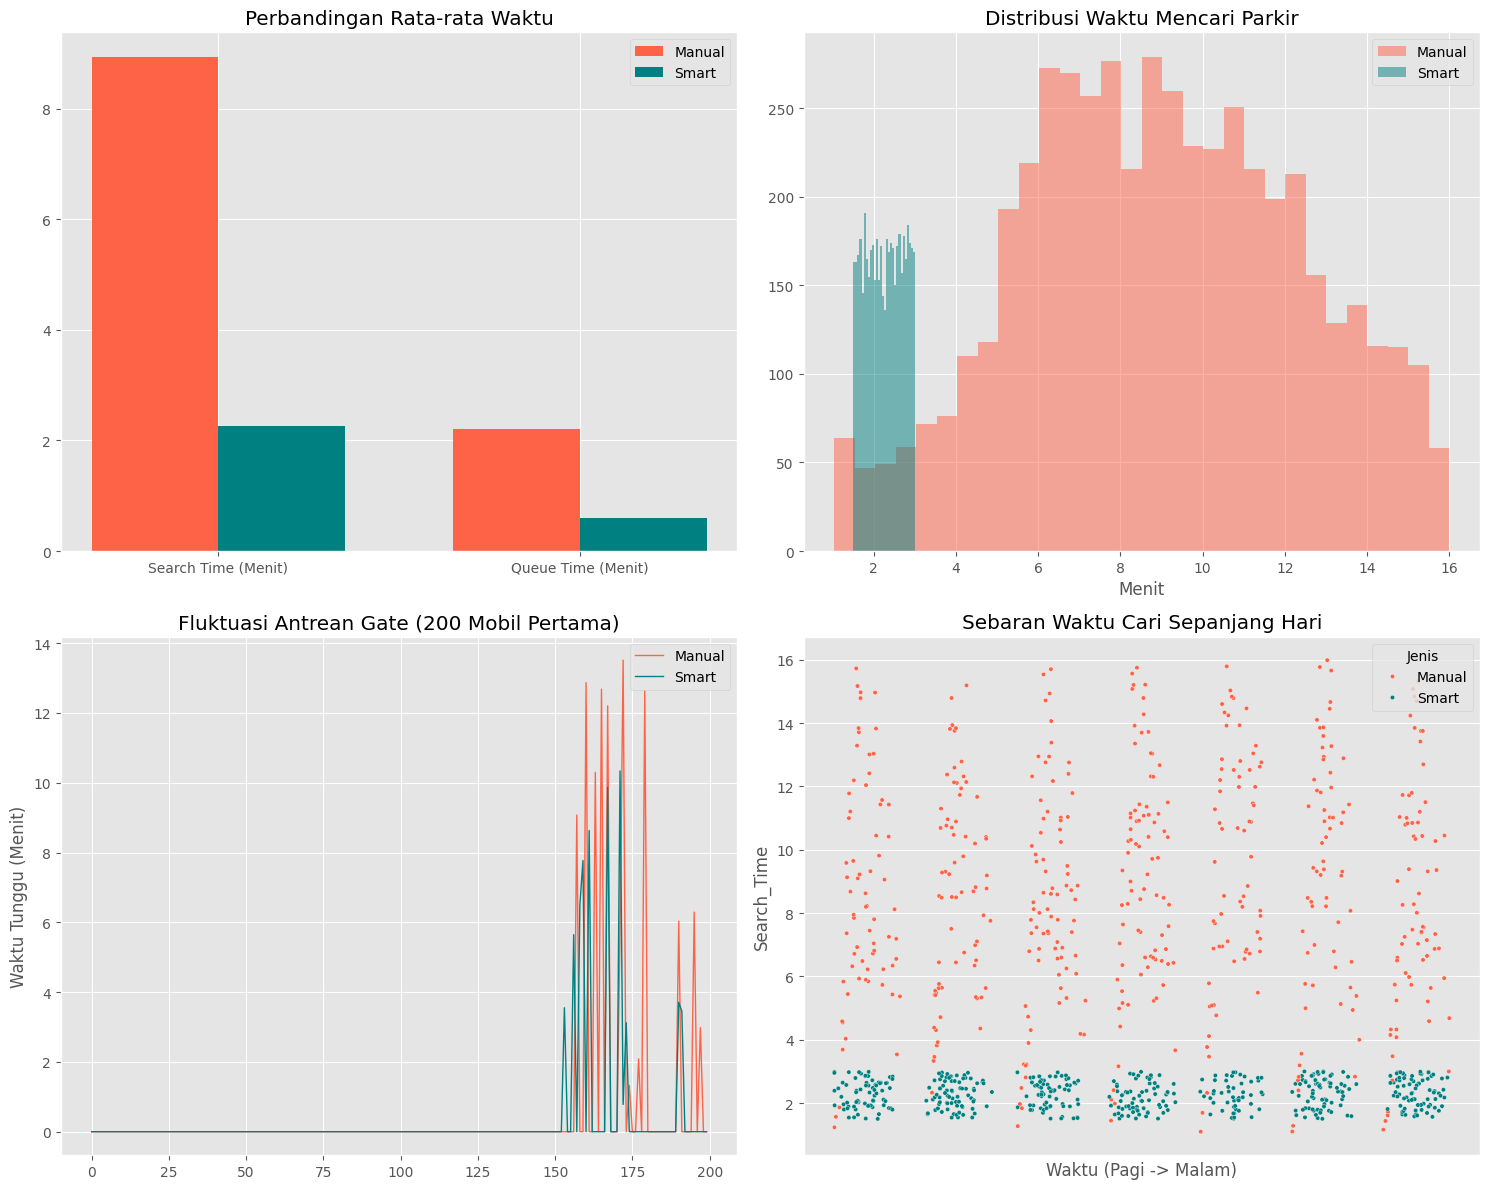

Grafik berhasil dibuat dan data hasil disimpan ke 'hasil_simulasi_lengkap.csv'


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Style
plt.style.use('ggplot') # Agar grafik terlihat modern
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# --- GRAFIK 1: PERBANDINGAN RATA-RATA (BAR CHART) ---
metrics = ['Search Time (Menit)', 'Queue Time (Menit)']
manual_scores = [avg_search_manual, avg_queue_manual]
smart_scores = [avg_search_smart, avg_queue_smart]

x = range(len(metrics))
width = 0.35

ax1 = axes[0, 0]
ax1.bar([i - width/2 for i in x], manual_scores, width, label='Manual', color='tomato')
ax1.bar([i + width/2 for i in x], smart_scores, width, label='Smart', color='teal')
ax1.set_title('Perbandingan Rata-rata Waktu')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()

# --- GRAFIK 2: HISTOGRAM DISTRIBUSI WAKTU CARI ---
# Melihat apakah waktunya stabil atau acak-acakan
ax2 = axes[0, 1]
ax2.hist(df_manual['Search_Time'], bins=30, alpha=0.5, label='Manual', color='tomato')
ax2.hist(df_smart['Search_Time'], bins=30, alpha=0.5, label='Smart', color='teal')
ax2.set_title('Distribusi Waktu Mencari Parkir')
ax2.set_xlabel('Menit')
ax2.legend()

# --- GRAFIK 3: ANTRIAN GATE SEIRING WAKTU (LINE CHART) ---
# Kita ambil sampel 200 mobil pertama agar grafik terbaca
sample_n = 200
ax3 = axes[1, 0]
ax3.plot(df_manual['Queue_Time'].iloc[:sample_n].values, label='Manual', color='tomato', linewidth=1)
ax3.plot(df_smart['Queue_Time'].iloc[:sample_n].values, label='Smart', color='teal', linewidth=1)
ax3.set_title(f'Fluktuasi Antrean Gate ({sample_n} Mobil Pertama)')
ax3.set_ylabel('Waktu Tunggu (Menit)')
ax3.legend()

# --- GRAFIK 4: SCATTER PLOT (Korelasi Kepadatan vs Waktu Cari) ---
# Membuktikan: Semakin ramai, Manual semakin lambat. Smart tetap stabil.
ax4 = axes[1, 1]
# Kita subsample biar ringan plotnya
samp = df_all.sample(1000) 
sns.scatterplot(data=samp, x='Arrival_Time', y='Search_Time', hue='Jenis', palette={'Manual':'tomato', 'Smart':'teal'}, ax=ax4, s=10)
ax4.set_title('Sebaran Waktu Cari Sepanjang Hari')
# Hilangkan label x yang berantakan (karena datetime)
ax4.set_xticks([]) 
ax4.set_xlabel('Waktu (Pagi -> Malam)')

plt.tight_layout()
plt.show()

# --- SIMPAN HASIL KE CSV UNTUK WEB APP NANTI ---
df_all.to_csv('hasil_simulasi_lengkap.csv', index=False)
print("Grafik berhasil dibuat dan data hasil disimpan ke 'hasil_simulasi_lengkap.csv'")